In [24]:
import numpy as np 
import pandas as pd 
from keras.utils import to_categorical 
from keras.callbacks import EarlyStopping 
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Activation, Flatten 
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.losses import categorical_crossentropy 
from sklearn.metrics import accuracy_score 
from keras.optimizers import Adam , RMSprop , Adagrad
from keras.regularizers import l2 
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.metrics import classification_report, confusion_matrix 
import matplotlib.pyplot as plt 
import seaborn as sns

In [25]:
!wget -O fer2013.csv https://www.dropbox.com/s/zi48lkarsg4kbry/fer2013.csv\?dl\=1

https://www.dropbox.com/s/zi48lkarsg4kbry/fer2013.csv\?dl\=1: HTTPS support not compiled in.


In [26]:
data_total = pd.read_csv('fer2013.csv')

# lire uniquement 10% des lignes du fichier CSV de manière aléatoire et de manière équilibrée par classe
data = data_total.groupby('emotion', group_keys=False).apply(lambda x: x.sample(frac=0.1))

data.shape

EmptyDataError: No columns to parse from file

In [27]:
data.head(5)

,emotion,pixels,Usage
2672,0,248 247 247 251 220 198 200 207 206 202 196 19...,Training
23473,0,61 55 50 46 38 56 46 78 65 56 66 53 91 115 142...,Training
26530,0,101 93 78 81 106 126 134 154 159 155 155 156 1...,Training
29971,0,195 181 164 171 197 176 167 170 178 175 190 18...,PublicTest
4701,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Training


In [28]:
data.Usage.value_counts()

Usage
Training       2873
PublicTest      358
PrivateTest     358
Name: count, dtype: int64

In [29]:
emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,495
1,Disgust,55
2,Fear,512
3,Happy,899
4,Sad,608
5,Surprise,400
6,Neutral,620


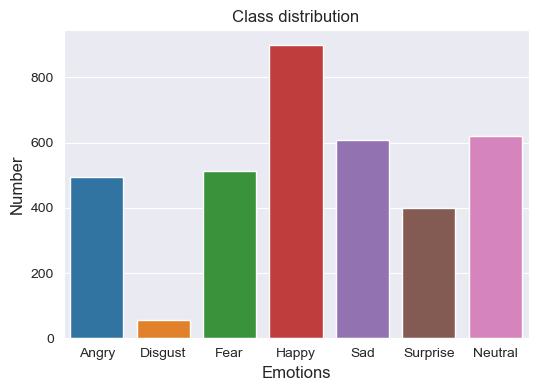

In [30]:
plt.figure(figsize=(6,4))
sns.barplot(x=emotion_counts.emotion, y=emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

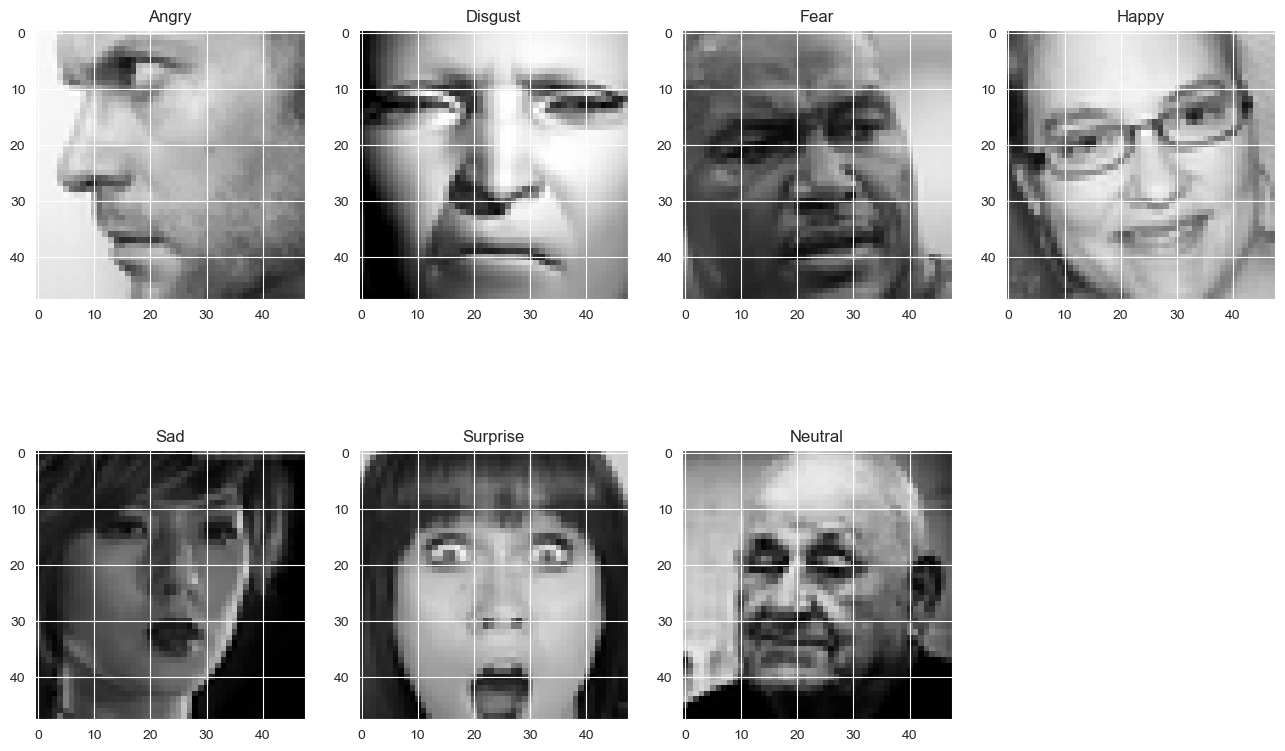

In [32]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split(), dtype=np.uint8)
    img = img.reshape(48, 48, 1)
    image = np.zeros((48, 48, 3), dtype=np.uint8)
    image[:,:,0] = img[:,:,0]
    image[:,:,1] = img[:,:,0]
    image[:,:,2] = img[:,:,0]
    return image, emotion

plt.figure(0, figsize=(16, 10))
for i in range(1, 8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2, 4, i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()

In [33]:
data_train = data[data['Usage'] == 'Training'].copy()
data_val = data[data['Usage'] == 'PublicTest'].copy()
data_test = data[data['Usage'] == 'PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))


train shape: (2873, 3), 
validation shape: (358, 3), 
test shape: (358, 3)


In [34]:
print(data_test)

       emotion                                             pixels        Usage
32335        0  75 92 98 100 98 95 89 74 49 27 18 21 22 25 25 ...  PrivateTest
34106        0  163 156 136 161 169 165 109 80 67 39 44 54 15 ...  PrivateTest
33977        0  26 24 25 28 39 39 42 43 45 47 46 45 45 60 76 9...  PrivateTest
33127        0  72 67 93 121 117 86 75 101 142 194 153 110 134...  PrivateTest
35820        0  183 197 141 72 92 75 62 57 58 54 51 49 63 40 4...  PrivateTest
...        ...                                                ...          ...
34161        6  231 228 170 111 118 123 124 116 108 123 114 11...  PrivateTest
35473        6  28 34 42 47 46 39 27 29 21 27 41 75 99 117 136...  PrivateTest
34058        6  67 76 90 108 121 127 132 134 134 135 135 139 1...  PrivateTest
33013        6  90 0 5 1 1 2 4 8 25 42 67 83 110 133 143 152 1...  PrivateTest
32823        6  50 42 32 26 25 22 55 115 133 131 132 150 148 1...  PrivateTest

[358 rows x 3 columns]


In [35]:
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

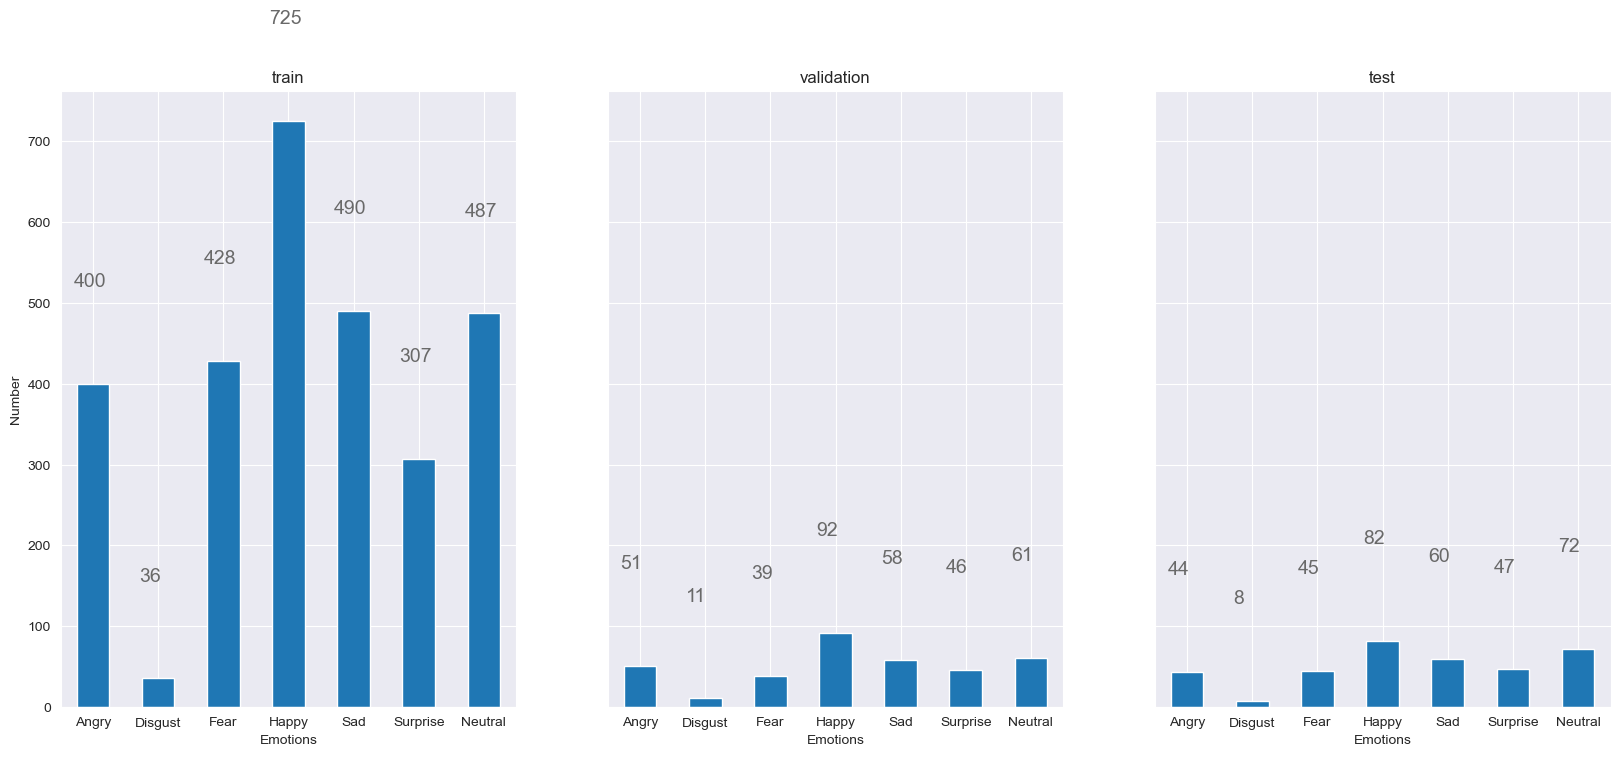

In [36]:
def setup_axe(axe, df, title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    # set individual bar labels using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x() - .05, i.get_height() + 120, \
                 str(round((i.get_height()), 2)), fontsize=14, color='dimgrey', rotation=0)

fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0], data_train, 'train')
setup_axe(axes[1], data_val, 'validation')
setup_axe(axes[2], data_test, 'test')
plt.show()

In [37]:
num_classes = 7
width, height = 48, 48
num_epochs = 5
batch_size = 64
num_features = 64

In [38]:
def CRNO(df, dataName):
  df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
  data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(- 1,width, height,1)/255.0
  data_Y = to_categorical(df['emotion'], num_classes)
  print(dataName, " X shape: {}, ", dataName, " Y shape: {}".format(data_X.shape, data_Y.shape))
  return data_X, data_Y
train_X, train_Y = CRNO(data_train, "train")
val_X, val_Y = CRNO(data_val, "val")
test_X, test_Y = CRNO(data_test, "test")

train  X shape: {},  train  Y shape: (2873, 48, 48, 1)
val  X shape: {},  val  Y shape: (358, 48, 48, 1)
test  X shape: {},  test  Y shape: (358, 48, 48, 1)


In [39]:
model = Sequential()

# module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Flatten
model.add(Flatten())

# Dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))
# Dropout
model.add(Dropout(0.25))

# Dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Dropout
model.add(Dropout(0.5))

# Dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output Layer
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), metrics=['accuracy'])
# Pour RMSprop
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['accuracy'])

# Pour Adagrad
model.compile(loss='categorical_crossentropy', optimizer=Adagrad(lr=0.001), metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 256)       2560      
                                                                 
 batch_normalization_9 (Bat  (None, 46, 46, 256)       1024      
 chNormalization)                                                
                                                                 
 activation_9 (Activation)   (None, 46, 46, 256)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 46, 46, 256)       590080    
                                                                 
 batch_normalization_10 (Ba  (None, 46, 46, 256)       1024      
 tchNormalization)                                               
                                                                 
 activation_10 (Activation)  (None, 46, 46, 256)      

In [40]:
data_generator = ImageDataGenerator( featurewise_center=False, featurewise_std_normalization=False, rotation_range=19, width_shift_range=0.1, height_shift_range=2.1, zoom_range=.1, horizontal_flip=True)
es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)
history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size), steps_per_epoch=len(train_X) / batch_size, epochs=num_epochs, verbose=2, callbacks = [es], validation_data=(val_X, val_Y))

C:\Users\said.sabri\AppData\Local\Temp\ipykernel_8424\2421682510.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size), steps_per_epoch=len(train_X) / batch_size, epochs=num_epochs, verbose=2, callbacks = [es], validation_data=(val_X, val_Y))


Epoch 1/5
44/44 - 272s - loss: 2.1254 - accuracy: 0.1692 - val_loss: 1.9718 - val_accuracy: 0.1089 - 272s/epoch - 6s/step
Epoch 2/5
44/44 - 260s - loss: 2.0382 - accuracy: 0.2085 - val_loss: 1.9977 - val_accuracy: 0.1089 - 260s/epoch - 6s/step
Epoch 3/5
44/44 - 255s - loss: 2.0418 - accuracy: 0.1987 - val_loss: 1.9903 - val_accuracy: 0.1089 - 255s/epoch - 6s/step
Epoch 4/5
44/44 - 268s - loss: 1.9891 - accuracy: 0.2182 - val_loss: 1.9789 - val_accuracy: 0.1089 - 268s/epoch - 6s/step
Epoch 5/5
44/44 - 267s - loss: 1.9812 - accuracy: 0.2168 - val_loss: 1.9419 - val_accuracy: 0.1145 - 267s/epoch - 6s/step


In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 5))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {: .4F}" .format(accuracy_score(test_true, test_pred)))

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize = False, title = None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    cm = confusion_matrix(y_true, y_pred)
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes, yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right', rotation_mode = 'anchor')
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for I in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, I, format(cm[I, j], fmt), ha = 'center', va = 'center', color = "white" if cm[I, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()